Encontradas 86437 imagens
Dispositivo: cuda
Epoch 1/5
Train Loss: 1.2010 | Val Loss: 0.9234
Acc: 0.7101 | Prec: 0.4341 | Recall: 0.5865 | F1-macro: 0.4735
------------------------------------------------------------
Epoch 2/5
Train Loss: 0.6294 | Val Loss: 0.3811
Acc: 0.7974 | Prec: 0.6229 | Recall: 0.8775 | F1-macro: 0.7024
------------------------------------------------------------
Epoch 3/5
Train Loss: 0.2471 | Val Loss: 0.2229
Acc: 0.9032 | Prec: 0.6807 | Recall: 0.9392 | F1-macro: 0.7513
------------------------------------------------------------
Epoch 4/5
Train Loss: 0.1106 | Val Loss: 0.0417
Acc: 0.9782 | Prec: 0.9652 | Recall: 0.9897 | F1-macro: 0.9768
------------------------------------------------------------
Epoch 5/5
Train Loss: 0.0952 | Val Loss: 0.0254
Acc: 0.9843 | Prec: 0.9732 | Recall: 0.9935 | F1-macro: 0.9829
------------------------------------------------------------
Treinamento concluído!
Métricas salvas em: alexnet_metrics.csv
Matriz de Confusão:
 [[13095   24

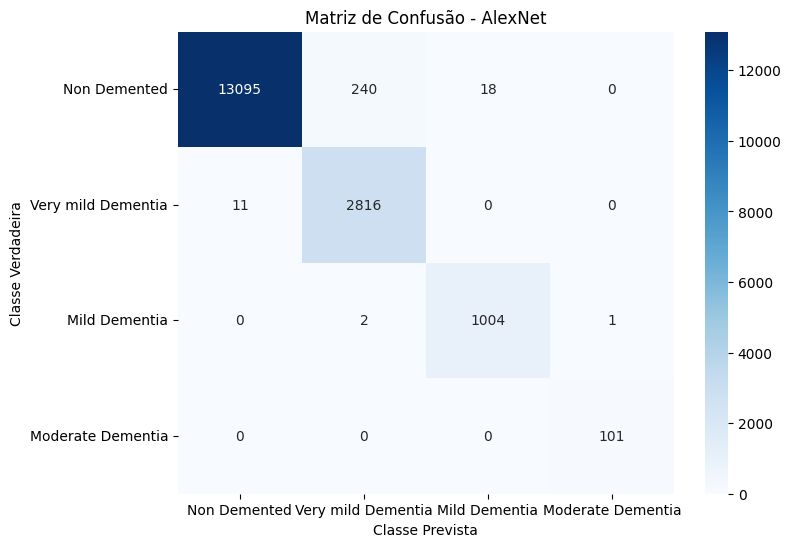

Preparando dados para análise SHAP...
Coletadas 64 imagens para análise SHAP
Calculando explicações SHAP...
SHAP values calculados com sucesso!
Tipo dos SHAP values: <class 'list'>
Número de classes: 4
Forma dos SHAP values para classe 0: (10, 3, 224, 224)
Gerando análises visuais explicativas dos resultados...


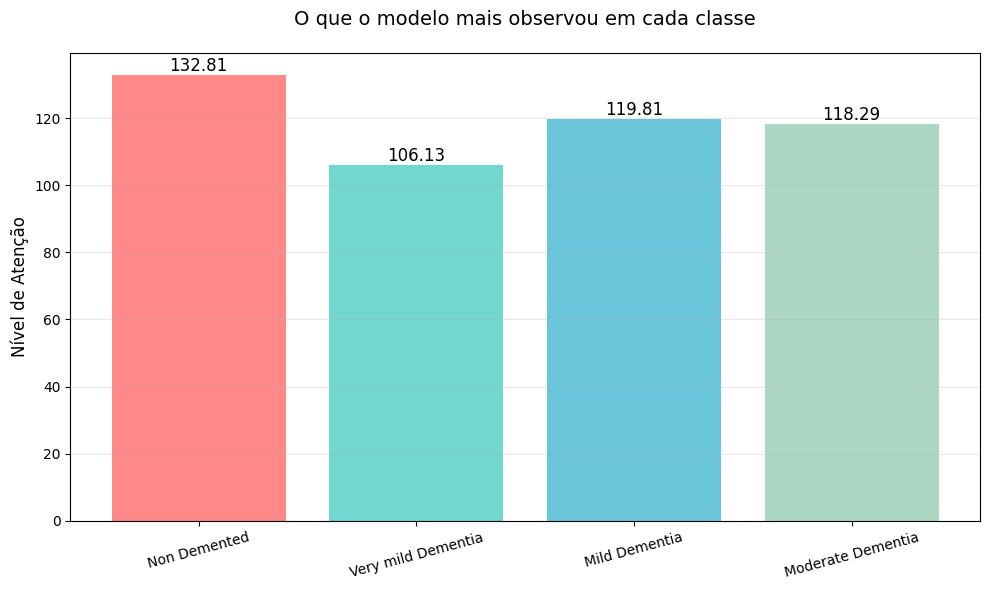

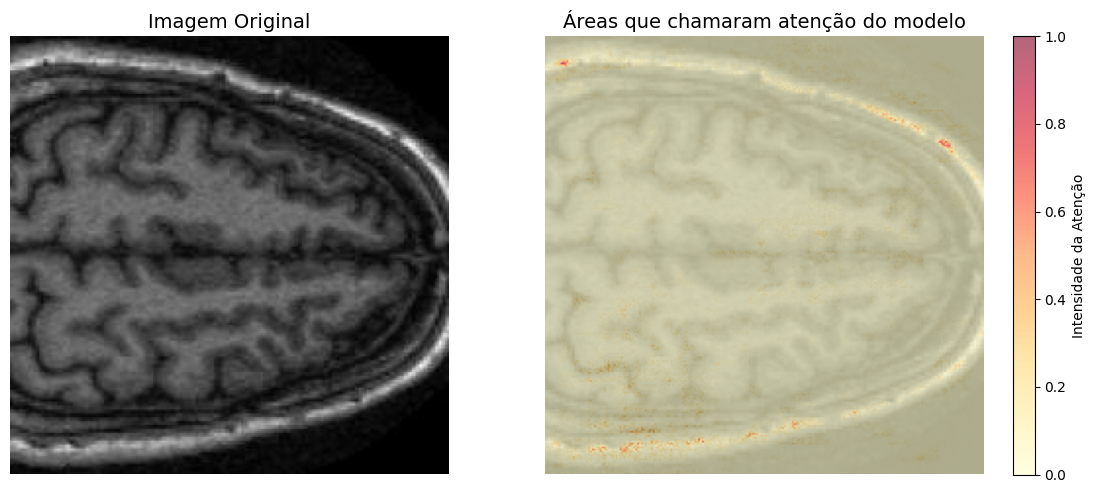

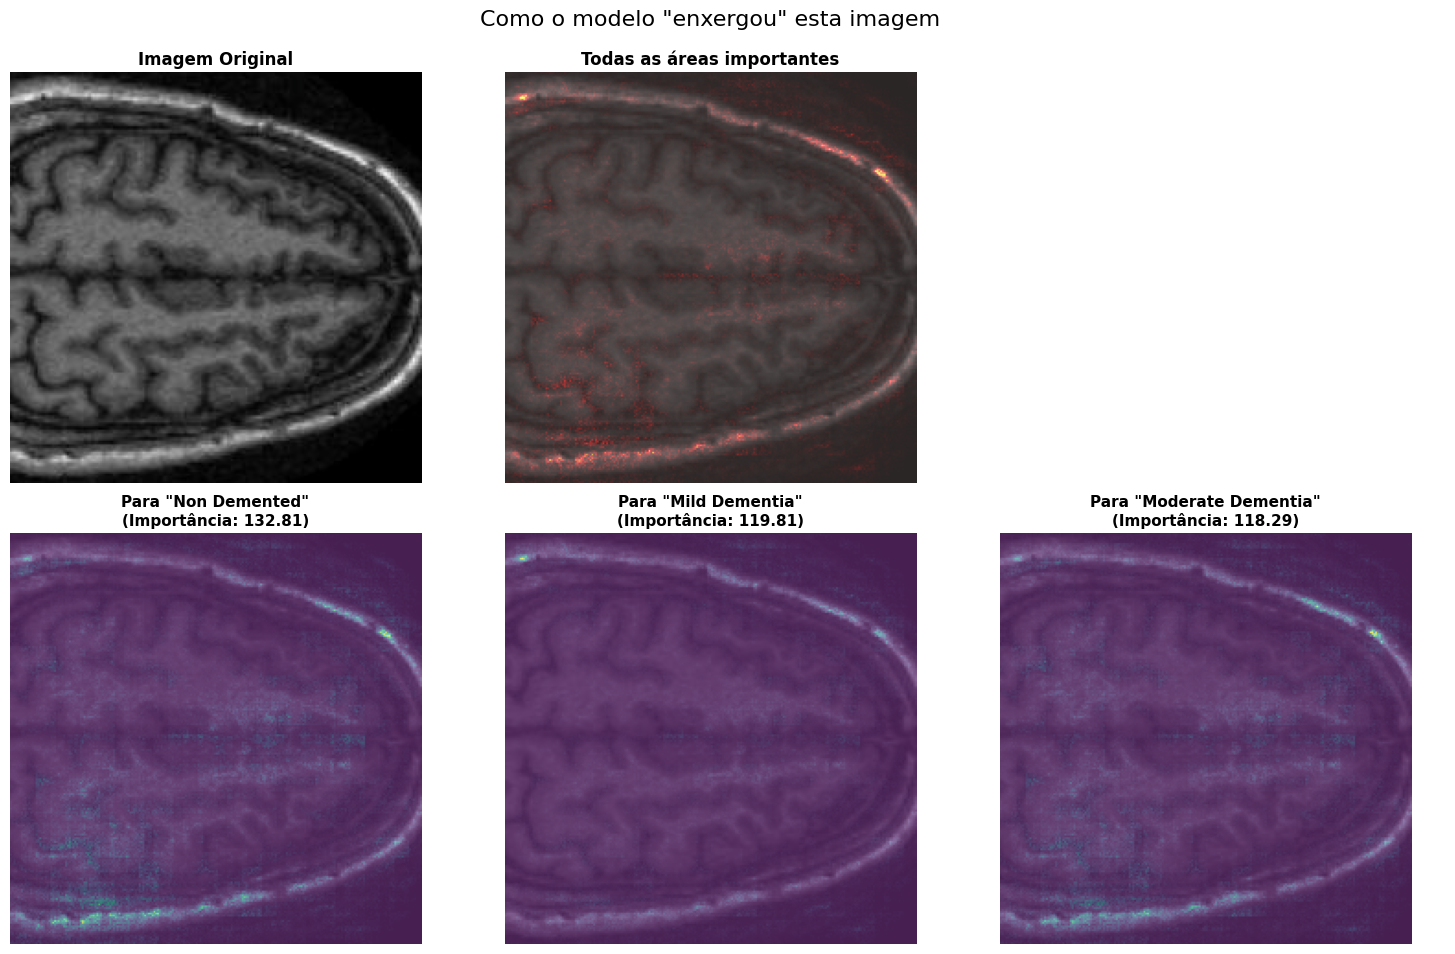

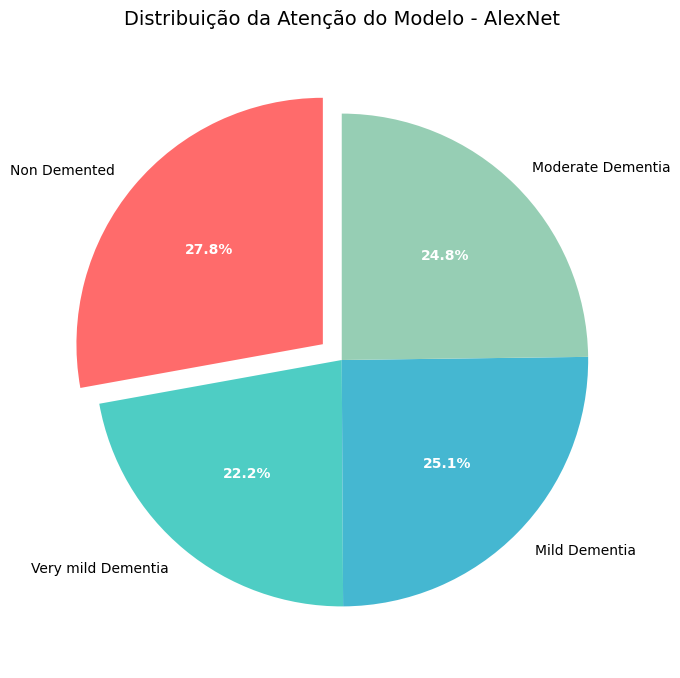


RELATÓRIO SIMPLES - ANÁLISE DA IMAGEM (AlexNet)

**Análise da Imagem:**
   • Classe mais provável: 'Non Demented'
   • Segunda opção: 'Mild Dementia'
   • Confiança na decisão: 27.8%

**Padrões identificados:**
   • O modelo considera múltiplas possibilidades

**Para leigos:**
   O algoritmo de IA analisou esta imagem e identificou padrões
   que se assemelham mais a 'Non Demented'.
   As áreas coloridas mostram onde o modelo 'prestou atenção'.

Visualizações explicativas criadas com sucesso!
Processo concluído!


In [2]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import polars as pl
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap

# ============================================================
# Download do dataset OASIS via kagglehub
# Link original: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
# ============================================================
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

# Converter dataset de imagens em DataFrame Polars para EDA
data_path = Path(path) / "Data"

# Coletar paths das imagens usando Polars
image_paths = []
for p in data_path.rglob('*.*'):
    if p.is_file():
        parts = p.parts
        if len(parts) >= 2:
            class_name = parts[-2]  # pasta = classe
            file_name = parts[-1]   # nome do arquivo
            image_paths.append((class_name, file_name, str(p)))

print(f"Encontradas {len(image_paths)} imagens")

# Criar DataFrame Polars
df = pl.DataFrame({
    'class': [x[0] for x in image_paths],
    'image': [x[1] for x in image_paths],
    'path': [x[2] for x in image_paths]
})

# Salvar metadados em arquivo Parquet
output_path = "oasis_dataset_metadata.parquet"
df.write_parquet(output_path)


# ============================================================
# Configurações básicas
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Transformações de pré-processamento
transform = transforms.Compose([
    transforms.Resize((248, 496)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset personalizado
class OASISDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = {
            'Non Demented': 0,
            'Very mild Dementia': 1,
            'Mild Dementia': 2,
            'Moderate Dementia': 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.row(idx)
        img_path = row[2]
        class_name = row[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[class_name]
        return image, label

# Carregar metadados
df = pl.read_parquet("oasis_dataset_metadata.parquet")
dataset = OASISDataset(df, transform=transform)

# Split treino/validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# ============================================================
# Modelo AlexNet (ajustando para evitar problemas com SHAP)
# ============================================================
class SafeAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SafeAlexNet, self).__init__()
        self.alexnet = models.alexnet(weights=None)
        
        # Desativar operações inplace em todas as ReLU
        for m in self.alexnet.modules():
            if isinstance(m, nn.ReLU):
                m.inplace = False
        
        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.alexnet(x)

model = SafeAlexNet(num_classes=4).to(device)

# Loss function com pesos (para classes desbalanceadas)
class_weights = torch.tensor([0.3215, 1.5744, 4.3201, 44.2812], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ============================================================
# Treinamento
# ============================================================
num_epochs = 5
metrics_history = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()

    # --- Training ---
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Estatísticas
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    epoch_time = time.time() - epoch_start

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1-macro: {f1:.4f}')
    print('-' * 60)

    # Guardar métricas
    metrics_history.append({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "epoch_time_sec": epoch_time
    })

    scheduler.step()

print("Treinamento concluído!")

# ============================================================
# Salvar métricas em CSV
# ============================================================
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv("alexnet_metrics.csv", index=False)
print("Métricas salvas em: alexnet_metrics.csv")

# ============================================================
# Matriz de Confusão
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusão:\n", cm)

# Salvar matriz em arquivo .npy
np.save("alexnet_confusion_matrix.npy", cm)

# --- Plot ---
class_names = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão - AlexNet')
plt.savefig('alexnet_confusion_matrix.png')
plt.show()

# ============================================================
# PREPARAÇÃO PARA SHAP - Coletar dados de teste
# ============================================================
print("Preparando dados para análise SHAP...")

# Coletar um subconjunto de imagens de teste para SHAP
test_images = []
test_labels = []
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        if i >= 2:  # Pegar apenas 2 batches para não sobrecarregar
            break
        test_images.append(images)
        test_labels.append(labels)

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

print(f"Coletadas {len(test_images)} imagens para análise SHAP")

# Converter imagens para numpy (apenas para visualização)
test_images_np = []
for i in range(min(10, len(test_images))):  # Pegar apenas algumas para visualização
    img = test_images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Desnormalizar
    img = np.clip(img, 0, 1)
    test_images_np.append(img)

test_labels = test_labels.cpu().numpy()

# ============================================================
# CÁLCULO DAS EXPLICAÇÕES SHAP
# ============================================================
print("Calculando explicações SHAP...")

def model_forward(x):
    """Função wrapper para o modelo compatível com SHAP"""
    x = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(x)
    return output.cpu().numpy()

# Usar GradientExplainer para modelos de deep learning
explainer = shap.GradientExplainer(model, test_images[:10].to(device))

# Calcular valores SHAP para as primeiras 10 imagens
shap_values = explainer.shap_values(test_images[:10].to(device))

print("SHAP values calculados com sucesso!")
print(f"Tipo dos SHAP values: {type(shap_values)}")
print(f"Número de classes: {len(shap_values)}")
print(f"Forma dos SHAP values para classe 0: {shap_values[0].shape}")

# ============================================================
# ANÁLISE EXPLICATIVA DOS RESULTADOS
# ============================================================
print("Gerando análises visuais explicativas dos resultados...")

def gerar_visualizacoes_explicativas(shap_values, test_images_np, test_labels, class_names):
    """
    Cria visualizações simples e intuitivas para apresentação
    """
    
    # 1. GRÁFICO DE BARRAS - IMPORTÂNCIA DAS CLASSES
    plt.figure(figsize=(10, 6))
    
    # Calcular importância total por classe
    importancias = []
    for i in range(4):
        importancia_total = np.sum(np.abs(shap_values[i][0]))
        importancias.append(importancia_total)
    
    cores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    barras = plt.bar(class_names, importancias, color=cores, alpha=0.8)
    
    # Adicionar valores nas barras
    for barra, valor in zip(barras, importancias):
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                f'{valor:.2f}', ha='center', va='bottom', fontsize=12)
    
    plt.title('O que o modelo mais observou em cada classe', fontsize=14, pad=20)
    plt.ylabel('Nível de Atenção', fontsize=12)
    plt.xticks(rotation=15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('alexnet_importancia_classes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. MAPA DE CALOR SIMPLIFICADO - "MAPAS DE ATENÇÃO"
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Imagem original
    axes[0].imshow(test_images_np[0])
    axes[0].set_title('Imagem Original', fontsize=14)
    axes[0].axis('off')
    
    # Mapa de atenção (combinação de todas as classes)
    mapa_atencao = np.zeros_like(shap_values[0][0][0])
    for i in range(4):
        mapa_atencao += np.abs(np.mean(shap_values[i][0], axis=0))
    
    # Normalizar
    mapa_atencao = (mapa_atencao - mapa_atencao.min()) / (mapa_atencao.max() - mapa_atencao.min())
    
    # Overlay suave
    axes[1].imshow(test_images_np[0], alpha=0.8)
    im = axes[1].imshow(mapa_atencao, cmap='YlOrRd', alpha=0.6)
    axes[1].set_title('Áreas que chamaram atenção do modelo', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], label='Intensidade da Atenção')
    
    plt.tight_layout()
    plt.savefig('alexnet_mapa_atencao.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. COMPARAÇÃO LADO A LADO - "O QUE O MODELO PENSOU"
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Título geral
    fig.suptitle('Como o modelo "enxergou" esta imagem\n', fontsize=16, y=0.95)
    
    # Linha 1: Original e mapa geral
    axes[0,0].imshow(test_images_np[0])
    axes[0,0].set_title('Imagem Original', fontweight='bold')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(test_images_np[0], alpha=0.7)
    axes[0,1].imshow(mapa_atencao, cmap='hot', alpha=0.5)
    axes[0,1].set_title('\nTodas as áreas importantes', fontweight='bold')
    axes[0,1].axis('off')
    
    axes[0,2].axis('off')  # Espaço vazio
    
    # Linha 2: Top 3 classes
    # Encontrar classes mais importantes
    class_ranking = []
    for i in range(4):
        importancia = np.sum(np.abs(shap_values[i][0]))
        class_ranking.append((class_names[i], importancia, i))
    
    class_ranking.sort(key=lambda x: x[1], reverse=True)
    
    for idx, (class_name, importancia, class_idx) in enumerate(class_ranking[:3]):
        mapa_classe = np.mean(np.abs(shap_values[class_idx][0]), axis=0)
        mapa_classe = (mapa_classe - mapa_classe.min()) / (mapa_classe.max() - mapa_classe.min() + 1e-8)
        
        axes[1,idx].imshow(test_images_np[0], alpha=0.7)
        axes[1,idx].imshow(mapa_classe, cmap='viridis', alpha=0.6)
        axes[1,idx].set_title(f'Para "{class_name}"\n(Importância: {importancia:.2f})', 
                            fontweight='bold', fontsize=11)
        axes[1,idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('alexnet_analise_completa.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. GRÁFICO DE PIZZA - DISTRIBUIÇÃO DA ATENÇÃO
    plt.figure(figsize=(8, 8))
    
    total_importancia = sum(importancias)
    porcentagens = [imp/total_importancia * 100 for imp in importancias]
    
    explode = [0.1 if i == np.argmax(importancias) else 0 for i in range(4)]
    
    wedges, texts, autotexts = plt.pie(porcentagens, labels=class_names, autopct='%1.1f%%',
                                      explode=explode, colors=cores, startangle=90)
    
    # Melhorar aparência
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.title('Distribuição da Atenção do Modelo - AlexNet', fontsize=14, pad=20)
    plt.savefig('alexnet_distribuicao_atencao.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. EXPLICAÇÃO TEXTUAL SIMPLES
    print("\n" + "="*60)
    print("RELATÓRIO SIMPLES - ANÁLISE DA IMAGEM (AlexNet)")
    print("="*60)
    
    classe_principal = class_ranking[0][0]
    segunda_classe = class_ranking[1][0]
    
    print(f"\n**Análise da Imagem:**")
    print(f"   • Classe mais provável: '{classe_principal}'")
    print(f"   • Segunda opção: '{segunda_classe}'")
    print(f"   • Confiança na decisão: {class_ranking[0][1]/total_importancia*100:.1f}%")
    
    print(f"\n**Padrões identificados:**")
    if class_ranking[0][1] > total_importancia * 0.4:
        print(f"   • O modelo está bastante confiante na classe '{classe_principal}'")
    else:
        print(f"   • O modelo considera múltiplas possibilidades")
    
    print(f"\n**Para leigos:**")
    print(f"   O algoritmo de IA analisou esta imagem e identificou padrões")
    print(f"   que se assemelham mais a '{classe_principal}'.")
    print(f"   As áreas coloridas mostram onde o modelo 'prestou atenção'.")

# Usar a função
try:
    if 'shap_values' in locals() and isinstance(shap_values, list):
        gerar_visualizacoes_explicativas(shap_values, test_images_np, test_labels, class_names)
        print("\nVisualizações explicativas criadas com sucesso!")
    else:
        print("SHAP values não foram calculados corretamente. Verificando estrutura...")
        print(f"shap_values existe: {'shap_values' in locals()}")
        if 'shap_values' in locals():
            print(f"Tipo: {type(shap_values)}")
except Exception as e:
    print(f"Erro ao criar visualizações explicativas: {e}")
    import traceback
    traceback.print_exc()

print("Processo concluído!")